## Importamos librerias

In [1]:
#EDA
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  

import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#Modelos
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.preprocessing  import KBinsDiscretizer, MinMaxScaler, SplineTransformer
from catboost import CatBoostRegressor

from xgboost import XGBRegressor

#Resultados
import shap

In [2]:
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

- CAMPAÑA: Año de la campaña.
- ID_FINCA: Identificador de finca.
- ID_ZONA: Identificador de una zona con una tipología de suelo común
- ID_ESTACION: Identificador de estación meteorológica.
- ALTITUD: Altitud media de la finca sobre el nivel del mar en metros.
- VARIEDAD: Código de variedad de la uva que se cultiva en la finca.
- MODO: Código del modo de cultivo.
- TIPO: Tipo de cultivo dentro de la variedad.
- COLOR: Identificador del color de la uva.
- SUPERFICIE: Superficie en hectáreas que ocupa la finca.
- PRODUCCION: Producción en kg. Obtenida en la campaña.

## Lectura de datos

In [3]:
df = pd.read_csv('C:/Users/denis/OneDrive/Escritorio/Datathon/datos/UH_2023_TRAIN.txt', sep= '|', header=0 )

In [4]:
df.columns = [col.lower().replace('-','_') for col in df.columns]

## Transformaciones

**Altitud**

In [5]:
def transform_altitud(alt):
    if type(alt) is str:
        alt_list = alt.split("-")
        alt_list = list(map(float, alt_list))
        return np.mean(alt_list) 
    return alt

In [6]:
df['altitud'] = df['altitud'].apply(lambda alt: transform_altitud(alt))

### Agrupacion de valores

Recategorizar aquellas columnas con muchos valores.

- Variedad
- Finca
- Altitud
- Zona

Hacerlo para **train**

Separamos parte del dataset que utilizamos para imputaciones y nuevas features

- 2022 lo usamos para imputar, pero a la hora del modelo lo sacamos porque no tiene el Target
- Para los modelos usamos 2021 como Test, entonces lo sacamos ahora para las transformaciones para no hacer leakage -> Transf df
- Luego podemos hacer backtesting con 2020, tomando 2021.

### Funciones para crear variables produccoin sin 21

In [7]:
def df_for_fe(data):
    transf = data[data.campaña != 21]
    return transf

In [8]:
def above_mean_col(data,col):
    df = df_for_fe(data)
    above_mean = pd.DataFrame(df.groupby(col)['produccion'].mean() > df.produccion.mean())
    above_mean = list(above_mean[above_mean['produccion']].index)
    data[f'{col}_above_mean'] = [1 if x in above_mean else 0 for x in data[col]]
    return data

In [9]:
def quantiles_col(data,col):
    df = df_for_fe(data)
    quantiles_df = pd.DataFrame(df.groupby(col)['produccion'].mean()).reset_index()
    Q1 = quantiles_df.produccion.quantile(0.25)
    Q2 = quantiles_df.produccion.quantile(0.5)
    Q3 = quantiles_df.produccion.quantile(0.75)
    
    quantiles_df[f'{col}_percentiles'] = [0 if x < Q1 else 1 if x < Q2 else 2 if x < Q3 else 3 for x in quantiles_df.produccion]

    data = data.merge(quantiles_df[[col,f'{col}_percentiles']], how='left', on = col) #Joineamos con el df transformado
    
    return data

In [10]:
df['altitud'] = df.groupby('id_estacion')['altitud'].transform(lambda x: x.fillna(x.mean()))

for col in ['altitud','variedad']:
    df=above_mean_col(df,col)
    
for col in ['id_finca','id_zona']:
    df=quantiles_col(df,col)

### Imputar NAs para superficie

- No usamos 2021 pues leakage, pero si usamos 2022. Al final si

In [11]:
df['superficie'] = df['superficie'].replace(0, np.nan)

Vamos cubriendo los NAs segun por menor a mayor jerarquia

In [12]:
df['superficie'] = df.groupby(['id_finca','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['id_zona','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['id_estacion','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['variedad'])['superficie'].transform(lambda x: x.fillna(x.mean()))

df.superficie.isna().sum()

0

Nos quedan 4 NAs en fincas_percentiles, hacemos fillna promedio, calculando este ultimo sin 21

In [13]:
df['id_finca_percentiles'] = df.id_finca_percentiles.fillna(df_for_fe(df).id_finca_percentiles.mean())

# Modelos

In [14]:
df_models = df[df.campaña < 22]
df_shift = df_models.copy()

In [15]:
df_shift['prod_shift1'] = df_shift.groupby(['id_finca','variedad','modo'])['produccion'].shift()
df_shift['prod_shift2'] = df_shift.groupby(['id_finca','variedad','modo'])['prod_shift1'].shift()

In [16]:
df_shift['prod_shift1'] = df_shift['prod_shift1'].fillna(-1)
df_shift['prod_shift2'] = df_shift['prod_shift2'].fillna(-1)

df_shift['var_prod_shift'] = [1 if x>y else 0 for x,y in zip(df_shift.prod_shift1, df_shift.prod_shift2)] 

df_shift['shifts_avg']=[(x+y)/2 if y!=-1 else x for x,y in zip(df_shift.prod_shift1,df_shift.prod_shift2)]
df_shift['shifts_max']=[x if x>y else y for x,y in zip(df_shift.prod_shift1,df_shift.prod_shift2)]

df_shift.drop(columns=['prod_shift1','prod_shift2'],inplace=True)

In [17]:
estaciones = pd.DataFrame(df_shift.groupby(['campaña','id_estacion']).agg(var_prod_est=('var_prod_shift', 'mean'))).reset_index()
df_shift = df_shift.merge(estaciones, how='left', on=['campaña','id_estacion'])

In [18]:
cat_cols = [
    'id_finca','id_zona',
    'id_estacion','variedad',
    "modo","tipo","color"
]

target = 'produccion'

X = df_shift.loc[:, df_shift.columns != target]
y = df_shift[target]

X[cat_cols] = X[cat_cols].astype("category")

X_train = X.iloc[:len(df_shift[df_shift['campaña']<21]),:]
X_test = X.iloc[len(df_shift[df_shift['campaña']<21]):,:]
y_train = y.iloc[:len(df_shift[df_shift['campaña']<21])]
y_test = y.iloc[len(df_shift[df_shift['campaña']<21]):]

Modelo 1

In [23]:
%%time 


# sample_weight = X_train['campaña'].apply(lambda x: 0.5 if x == 19 else 1).values
#Modelo
rf = RandomForestRegressor(random_state=99)

#Entrenamiento
# rf.fit(X_train, y_train, sample_weight=sample_weight)
rf.fit(X_train, y_train)

#Predicciones
prediction = rf.predict(X_test)

#Resultados
rmse_score(y_test, prediction)

Wall time: 5.96 s


5451.055561486305

Modelo 2

In [19]:
ids = ['campaña', 'id_finca', 'id_zona', 'id_estacion','variedad']
    
binarias =   ['modo', 'tipo', 'color']

discret = ['altitud']

rest_cols = ['superficie', 'id_finca_percentiles','id_zona_percentiles']

ctransformer = ColumnTransformer([
   ('kbins', KBinsDiscretizer() , discret),
#     ('multi', OneHotEncoder(), binarias),
#      ('PCA', PCA(n_components=2), extra_weather),
   ('scaler', MinMaxScaler(), rest_cols)],
    remainder='passthrough')

model = RandomForestRegressor(random_state=99
                              ,n_estimators=200
                               ,min_samples_leaf = 3
                               ,n_jobs = -1
                               ,max_features= 'sqrt'
#                                ,min_samples_split = 1
                               ,max_depth = 100
#                               ,criterion = 'friedman_mse'
                             )

pipeline = make_pipeline(ctransformer,model)

pipeline.fit(X_train,y_train)

preds_train = pipeline.predict(X_train)
preds_test = pipeline.predict(X_test)

print(f'RMSE train: {rmse_score(y_train,preds_train)}, RMSE test: {rmse_score(y_test,preds_test)}')

RMSE train: 4464.244832027151, RMSE test: 5441.857832683388


# Predicciones

Creamos features para 2022

In [20]:
df_shift = df.copy()
df_shift['prod_shift1'] = df_shift.groupby(['id_finca','variedad','modo'])['produccion'].shift()
df_shift['prod_shift2'] = df_shift.groupby(['id_finca','variedad','modo'])['prod_shift1'].shift()

In [21]:
df_shift['prod_shift1'] = df_shift['prod_shift1'].fillna(-1)
df_shift['prod_shift2'] = df_shift['prod_shift2'].fillna(-1)

df_shift['var_prod_shift'] = [1 if x>y else 0 for x,y in zip(df_shift.prod_shift1, df_shift.prod_shift2)] 

df_shift['shifts_avg']=[(x+y)/2 if y!=-1 else x for x,y in zip(df_shift.prod_shift1,df_shift.prod_shift2)]
df_shift['shifts_max']=[x if x>y else y for x,y in zip(df_shift.prod_shift1,df_shift.prod_shift2)]

df_shift.drop(columns=['prod_shift1','prod_shift2'],inplace=True)

In [22]:
estaciones = pd.DataFrame(df_shift.groupby(['campaña','id_estacion']).agg(var_prod_est=('var_prod_shift', 'mean'))).reset_index()
df_shift = df_shift.merge(estaciones, how='left', on=['campaña','id_estacion'])

In [23]:
data_22 = df_shift[df_shift.campaña==22]

In [24]:
cat_cols = [
    'id_finca','id_zona',
    'id_estacion','variedad',
    "modo","tipo","color"
]

target = 'produccion'

X = df_shift.loc[:, df_shift.columns != target]
y = df_shift[target]

X[cat_cols] = X[cat_cols].astype("category")

X_train = X.iloc[:len(df_shift[df_shift['campaña']<22]),:]
X_test = X.iloc[len(df_shift[df_shift['campaña']<22]):,:]
y_train = y.iloc[:len(df_shift[df_shift['campaña']<22])]
y_test = y.iloc[len(df_shift[df_shift['campaña']<22]):]

Guardamos las predicciones que salen del modelo viejo

In [25]:
preds_viejo = pipeline.predict(X_test)
len(preds_viejo)

1075

In [26]:
len(X_test)

1075

Modelo reentrenado

In [27]:
ids = ['campaña', 'id_finca', 'id_zona', 'id_estacion','variedad']
    
binarias =   ['modo', 'tipo', 'color']

discret = ['altitud']

rest_cols = ['superficie', 'id_finca_percentiles','id_zona_percentiles']

ctransformer = ColumnTransformer([
   ('kbins', KBinsDiscretizer() , discret),
#     ('multi', OneHotEncoder(), binarias),
#      ('PCA', PCA(n_components=2), extra_weather),
   ('scaler', MinMaxScaler(), rest_cols)],
    remainder='passthrough')

model = RandomForestRegressor(random_state=99
                              ,n_estimators=200
                               ,min_samples_leaf = 3
                               ,n_jobs = -1
                               ,max_features= 'sqrt'
#                                ,min_samples_split = 1
                               ,max_depth = 100
#                               ,criterion = 'friedman_mse'
                             )

pipeline = make_pipeline(ctransformer,model)

pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('kbins', KBinsDiscretizer(),
                                                  ['altitud']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['superficie',
                                                   'id_finca_percentiles',
                                                   'id_zona_percentiles'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, max_features='sqrt',
                                       min_samples_leaf=3, n_estimators=200,
                                       n_jobs=-1, random_state=99))])

In [28]:
predicciones_envio = pipeline.predict(X_test)

In [29]:
predicciones_envio.shape

(1075,)

In [30]:
preds_viejo.shape

(1075,)

In [31]:
predicciones = pd.DataFrame(zip(predicciones_envio,preds_viejo))

In [32]:
predicciones.columns = ['modelo_nuevo','modelo_viejo']

In [33]:
predicciones['dif'] = abs(predicciones['modelo_viejo'] - predicciones['modelo_nuevo'])

In [34]:
predicciones.describe()

,modelo_nuevo,modelo_viejo,dif
count,1075.00,1075.00,1075.00
mean,10152.07,10058.38,685.30
std,12552.67,12102.18,909.66
min,168.27,184.29,0.00
25%,2853.67,2938.80,124.04
50%,5981.18,6358.59,343.57
75%,12232.74,12100.22,883.41
max,113854.45,112014.27,9248.84


In [38]:
df_2 = df.copy()

In [46]:
df_2.loc[df_2['produccion'].isna(),'produccion'] = predicciones.modelo_nuevo.values

In [47]:
df_2

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,altitud_above_mean,variedad_above_mean,id_finca_percentiles,id_zona_percentiles
0,14,76953,515,4,660.00,26,2,0,1,2.64,22215.00,0,1,3.00,3
1,14,84318,515,4,660.00,26,2,0,1,2.64,22215.00,0,1,3.00,3
2,14,85579,340,4,520.00,32,2,0,1,2.91,20978.00,1,1,3.00,3
3,14,69671,340,4,520.00,32,2,0,1,2.91,40722.00,1,1,3.00,3
4,14,14001,852,14,659.10,81,1,0,1,2.82,14126.00,1,0,3.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9596,22,37461,239,6,700.00,52,2,0,1,3.68,28163.12,1,1,3.00,3
9597,22,58769,239,6,700.00,32,2,0,1,4.25,38248.20,1,1,3.00,3
9598,22,58769,239,6,700.00,59,2,0,1,4.07,40492.94,1,0,3.00,3
9599,22,88928,239,6,700.00,40,2,0,1,4.57,43581.16,1,1,3.00,3


El nuevo eleva un poco los valores de las prediccoines

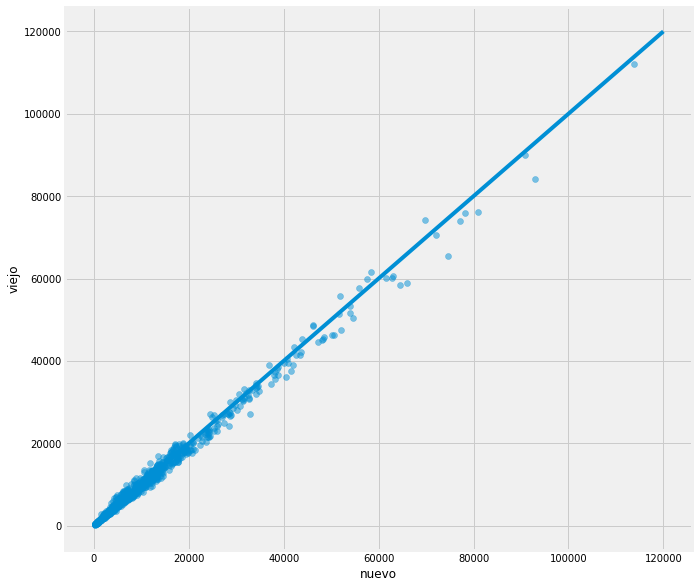

In [35]:
plt.figure(figsize=(10,10))
plt.scatter(x=predicciones.modelo_nuevo, y=predicciones.modelo_viejo , alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('nuevo')
plt.ylabel('viejo')
plt.show()

Agarramos predicciones del modelo que entrena tambien con 2021, pues no hay mucha diferencia y debe ser mejor

In [65]:
X_test['produccion'] = predicciones_envio

In [66]:
entrega_1 = X_test.copy()

In [67]:
entrega_1 = entrega_1[['id_finca', 'variedad', 'modo', 'tipo','color','superficie','produccion']]

In [68]:
entrega_1.columns = [x.upper() for x in entrega_1.columns]

In [69]:
entrega_1 = entrega_1.sort_values(['ID_FINCA', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR', 'SUPERFICIE'],ascending=True)

In [70]:
entrega_1['SUPERFICIE'] = round(entrega_1['SUPERFICIE'],2)

In [71]:
entrega_1['PRODUCCION'] = round(entrega_1['PRODUCCION'],2)

In [74]:
entrega_1

,ID_FINCA,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
9240,439,9,2,0,0,1.08,2990.17
9231,447,40,2,0,1,0.47,2495.21
8788,523,32,2,0,1,0.65,1973.98
9581,702,59,2,0,1,1.13,7712.20
8746,797,59,1,0,1,7.51,14395.19
...,...,...,...,...,...,...,...
9549,99282,59,2,0,1,1.62,7808.52
9310,99377,52,2,0,1,0.65,2131.12
8655,99693,81,1,0,1,6.34,32654.14
8540,99793,52,2,0,1,0.13,8350.46


In [127]:
entrega_1.to_csv("UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_1.txt", header=None, index=None, sep='|', mode='w')